In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import geopy.distance
from sklearn.cluster import KMeans

# Section 1: EDA

## 1. How many observations are in the dataset? Are there null values?

In [2]:
# Load the dataset
data = pd.read_csv('202307-divvy-tripdata.csv')

# Get the number of observations and check for null values
print(data.shape)
print(data.isnull().sum())

#check if there is duplicated entries
print(data[data.duplicated()==True].count())

(767650, 13)
ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    122943
start_station_id      122943
end_station_name      130304
end_station_id        130304
start_lat                  0
start_lng                  0
end_lat                 1254
end_lng                 1254
member_casual              0
dtype: int64
ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64


## 2. How would you clean and prepare the data for analysis?

In [3]:
# Dataframe without null values
start_station_info = data.dropna(subset=['start_station_name', 'start_station_id', 'start_lat', 'start_lng'])
end_station_info = data.dropna(subset=['end_station_name', 'end_station_id', 'end_lat', 'end_lng'])

# Create dictionaries for start latitude and longitude
start_station_name_dict_lat = start_station_info.set_index('start_lat')['start_station_name'].to_dict()
start_station_name_dict_lng = start_station_info.set_index('start_lng')['start_station_name'].to_dict()
start_station_id_dict_lat = start_station_info.set_index('start_lat')['start_station_id'].to_dict()
start_station_id_dict_lng = start_station_info.set_index('start_lng')['start_station_id'].to_dict()

# Create dictionaries for end latitude and longitude
end_station_name_dict_lat = end_station_info.set_index('end_lat')['end_station_name'].to_dict()
end_station_name_dict_lng = end_station_info.set_index('end_lng')['end_station_name'].to_dict()
end_station_id_dict_lat = end_station_info.set_index('end_lat')['end_station_id'].to_dict()
end_station_id_dict_lng = end_station_info.set_index('end_lng')['end_station_id'].to_dict()

# Map missing station names and IDs using latitude
data.loc[data['start_station_name'].isnull(), 'start_station_name'] = data['start_lat'].map(start_station_name_dict_lat)
data.loc[data['start_station_id'].isnull(), 'start_station_id'] = data['start_lat'].map(start_station_id_dict_lat)
data.loc[data['end_station_name'].isnull(), 'end_station_name'] = data['end_lat'].map(end_station_name_dict_lat)
data.loc[data['end_station_id'].isnull(), 'end_station_id'] = data['end_lat'].map(end_station_id_dict_lat)

# If the name/id is still missing, map using longitude
data.loc[data['start_station_name'].isnull(), 'start_station_name'] = data['start_lng'].map(start_station_name_dict_lng)
data.loc[data['start_station_id'].isnull(), 'start_station_id'] = data['start_lng'].map(start_station_id_dict_lng)
data.loc[data['end_station_name'].isnull(), 'end_station_name'] = data['end_lng'].map(end_station_name_dict_lng)
data.loc[data['end_station_id'].isnull(), 'end_station_id'] = data['end_lng'].map(end_station_id_dict_lng)

In [4]:
# Check missing values left
print(data.isnull().sum())

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name     74924
start_station_id       74924
end_station_name      130304
end_station_id        130304
start_lat                  0
start_lng                  0
end_lat                 1254
end_lng                 1254
member_casual              0
dtype: int64


## 3. Which bike types are popular and which ones aren't? Check if being a member or casual rider makes a difference in bike choice.

In [6]:
# Analyze the popularity of bike types based on the number of rides
# It was found that docked_bike is just an old name for classic_bike, so it is replaced
data['rideable_type'] = data['rideable_type'].replace({'docked_bike': 'classic_bike'})
rideable_type_counts = data['rideable_type'].value_counts()

# Group bike types by member and casual riders
rideable_type_by_user_type = data.groupby(['rideable_type', 'member_casual'])['ride_id'].count()

# Display results
print(rideable_type_counts)
print(rideable_type_by_user_type)

electric_bike    387096
classic_bike     380554
Name: rideable_type, dtype: int64
rideable_type  member_casual
classic_bike   casual           161306
               member           219248
electric_bike  casual           170052
               member           217044
Name: ride_id, dtype: int64


## 4. Time check! What are the peak and off-peak riding times during the day?

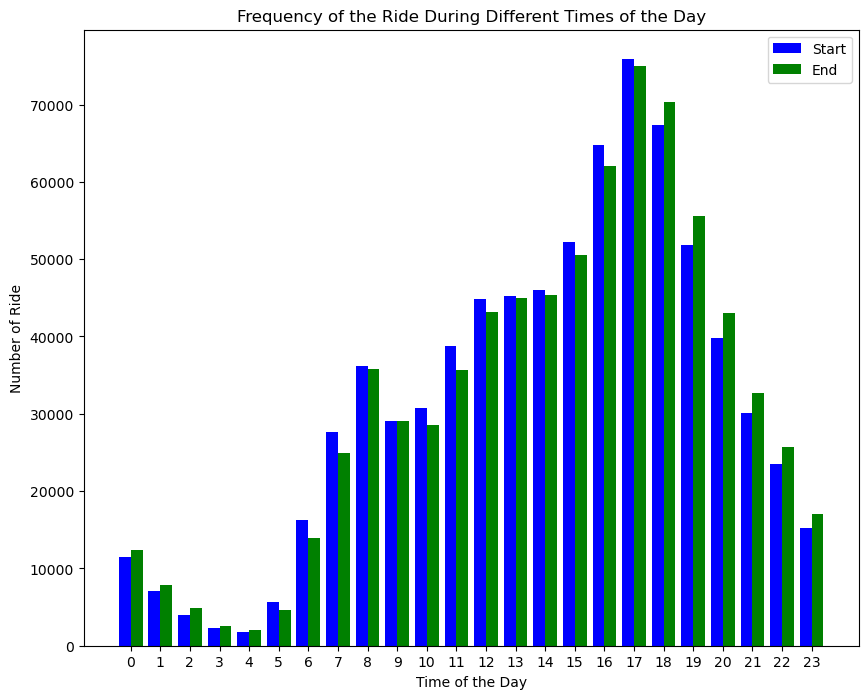

In [7]:
# Convert 'started_at' and 'ended_at' to datetime
data['started_at'] = pd.to_datetime(data['started_at'])
data['ended_at'] = pd.to_datetime(data['ended_at'])

# Add start hour
data['start_hour'] = data['started_at'].dt.hour
data['end_hour'] = data['ended_at'].dt.hour

# Group ride counts by each hour of the day
peak_hours_start = data.groupby('start_hour')['ride_id'].count()
peak_hours_end = data.groupby('end_hour')['ride_id'].count()

# Create an array that includes the 24 hours of a day for plotting
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

# Create bar graph that includes both the starting hours and ending hours as the variable, and specify the details of the plot and the bars
fig, ax = plt.subplots(figsize = (10,8))
bar_width = 0.4
bar1 = ax.bar(x - bar_width / 2, peak_hours_start , bar_width, label='Start',color = 'b')
bar2 = ax.bar(x + bar_width / 2, peak_hours_end , bar_width, label='End',color='g')

# Labeling the graph
ax.set_xlabel('Time of the Day')
ax.set_ylabel('Number of Ride')
ax.set_title('Frequency of the Ride During Different Times of the Day')
ax.set_xticks(x)
ax.legend()

# Section 2: Time used and Time range determination

## Check the average time spent on a ride

time_range
0-10mins        350998
10-20mins       232651
20-45mins       140118
3hrs-1day         2482
45mins-3hrs      40337
beyond 1 day      1064
Name: time_used, dtype: int64
ride_id                     CFB4246E9FAB59DA
rideable_type                   classic_bike
started_at               2023-07-03 10:49:37
ended_at                 2023-08-08 04:31:01
start_station_name    Wabash Ave & Wacker Pl
start_station_id                TA1307000131
end_station_name                         NaN
end_station_id                           NaN
start_lat                          41.886875
start_lng                          -87.62603
end_lat                                  NaN
end_lng                                  NaN
member_casual                         casual
start_hour                                10
end_hour                                   4
time_used                            51461.4
time_range                      beyond 1 day
Name: 606405, dtype: object
3546


Text(0.5, 1.0, 'Histogram of the time used for each ride')

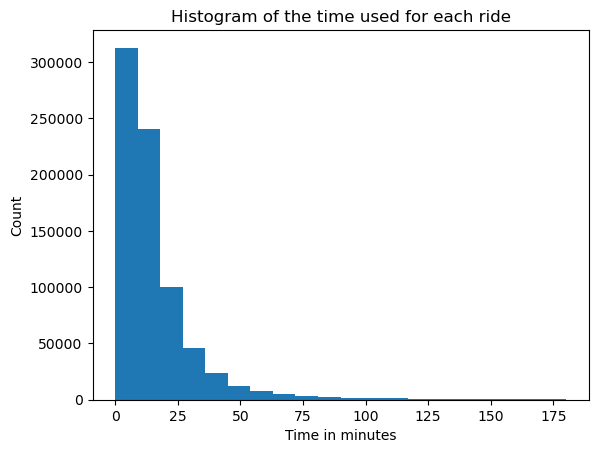

In [9]:
# Find the time in minutes used for each ride
data['time_used'] = (data['ended_at'] - data['started_at']).dt.total_seconds() / 60

# Cut the time range into 6 different catergories
time_selection = [
    (data['time_used'] <= 10),
    (data['time_used'] <= 20) & (data['time_used'] > 10),
    (data['time_used'] <= 45) & (data['time_used'] > 20),
    (data['time_used'] <= 180) & (data['time_used'] > 45),
    (data['time_used'] <= 1440) & (data['time_used'] > 180),
    (data['time_used'] > 1440)
]
# Specify the string name for each time range
time_range = [
    '0-10mins',
    '10-20mins',
    '20-45mins',
    '45mins-3hrs',
    '3hrs-1day',
    'beyond 1 day'
]

# Add time_range to be a new column of the data
data['time_range'] = np.select(time_selection,time_range)

        
# Check the number of entries per time_range
print(data.groupby('time_range')['time_used'].count())

# Look up the entry with the highest time used to check if there is an error in the calculation of time_used
print(data.iloc[data['time_used'].idxmax()])

# Explore the data by checking how its histogram looks
print(data['time_used'][data['time_used'] > 180].count())
plt.hist(x = data['time_used'],bins = 20,range=(0, 180)) # Even after limiting the range to be up to 180, it is still highly skewed to the left.\

plt.xlabel('Time in minutes')
plt.ylabel('Count')
plt.title('Histogram of the time used for each ride')

## Compute for the cost for each ride with the unit price from the website

In [11]:
# Categorize the ride base on both the rider's membership and the type of transportation
categories = [
    (data['member_casual'] == 'casual') & ((data['rideable_type'] == 'classic_bike') | (data['rideable_type'] == 'docked_bike')),
    (data['member_casual'] == 'casual') & (data['rideable_type'] == 'electric_bike'),
    (data['member_casual'] == 'member') & (data['rideable_type'] == 'electric_bike'),
    (data['member_casual'] == 'member') & (data['rideable_type'] == 'classic_bike') & (data['time_used'] > 45),
]

# Apply the price calculation to each category
costs = [
    data['time_used'] * 0.17 + 1,
    data['time_used'] * 0.42 + 1,
    data['time_used'] * 0.17,
    (data['time_used'] - 45) * 0.17,
]

# Default value for members who rides the classic bike for under 45 mins
default_cost = 0

# Use np.select to calculate the cost for each ride
data['cost'] = np.select(categories, costs, default_cost)

## Visualize the time and cost data with heatmaps (Initial)


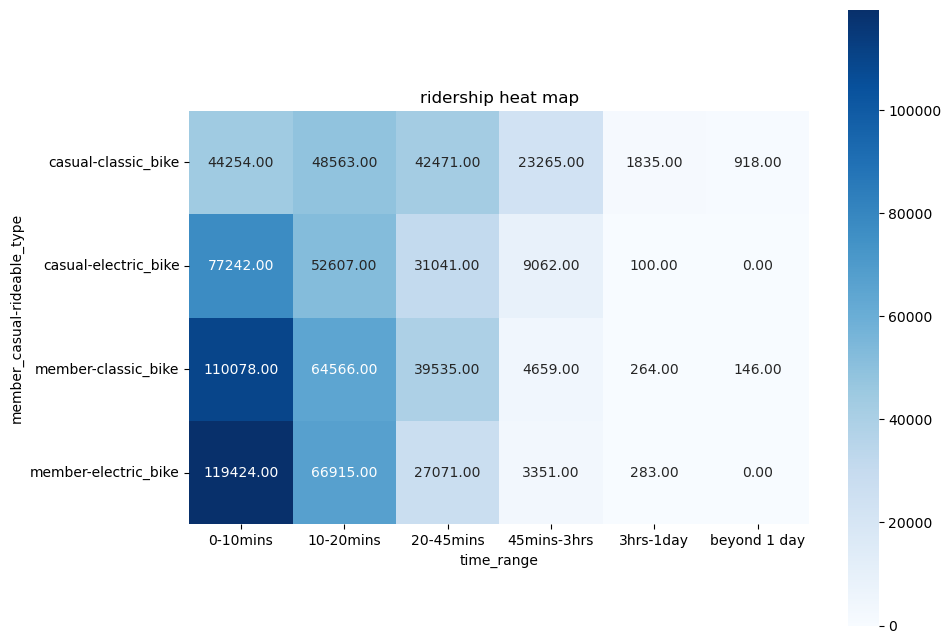

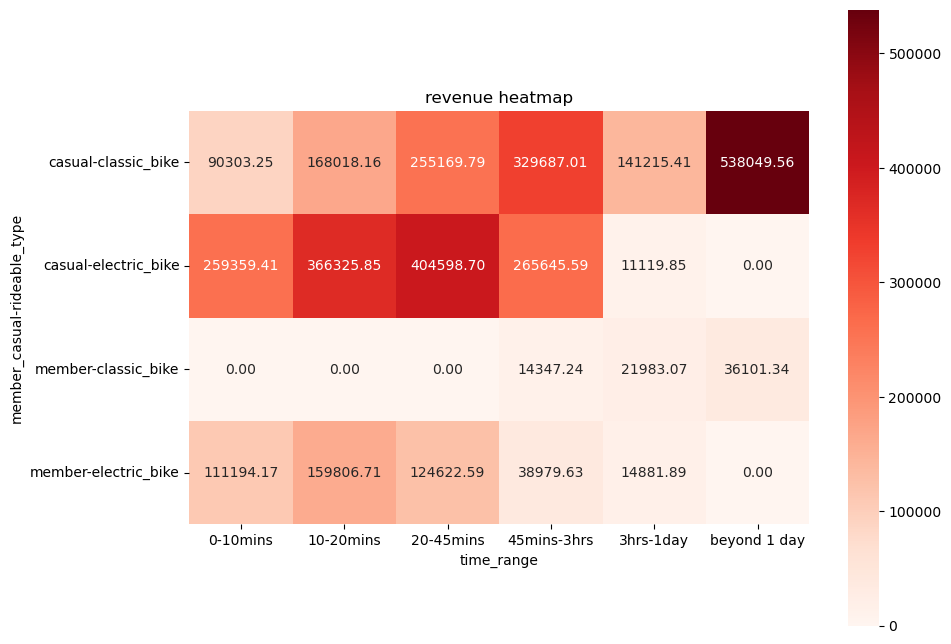

In [12]:
#This heatmap should contain the number of users with different time used as the x-value, and the different type of membership
    #plus the type of bikes as y-value

# Specify an order for the categorical data for time range for better representation of the heat map
data['time_range'] = pd.Categorical(data['time_range'], categories=["0-10mins", "10-20mins", "20-45mins", "45mins-3hrs", "3hrs-1day", "beyond 1 day"])
#data = data.sort_values('time_range')
    

# Rearrange the data using pivot_table for the format to fit for heatmap generation
Time = data.pivot_table(index=['member_casual','rideable_type'], columns='time_range',values='time_used',aggfunc = 'count') # Count the number of entries
Cost = data.pivot_table(index=['member_casual','rideable_type'], columns='time_range',values='cost',aggfunc = 'sum') # Count the total income

# Create the heatmap for the time used and specify the size of the graph
plt.figure(figsize=(10, 8))
# This is a blue-shade heatmap wtih the numbers having 2 decimal places
sns.heatmap(Time, cmap='Blues', annot=True, fmt=".2f", cbar=True, square = True) 
plt.title('ridership heat map')
plt.show()

# Create the heatmap for the revenue created and specify the size of the graph
plt.figure(figsize=(10, 8))
# This is a red-shade heatmap wtih the numbers having 2 decimal places
sns.heatmap(Cost, cmap='Reds',annot = True, fmt='.2f', cbar = True, square = True)
plt.title('revenue heatmap')
plt.show()

## Visualize the time and cost data with heatmaps (Final) {This is moved here because of the removal of 'beyond 1 day' step should be delayed}

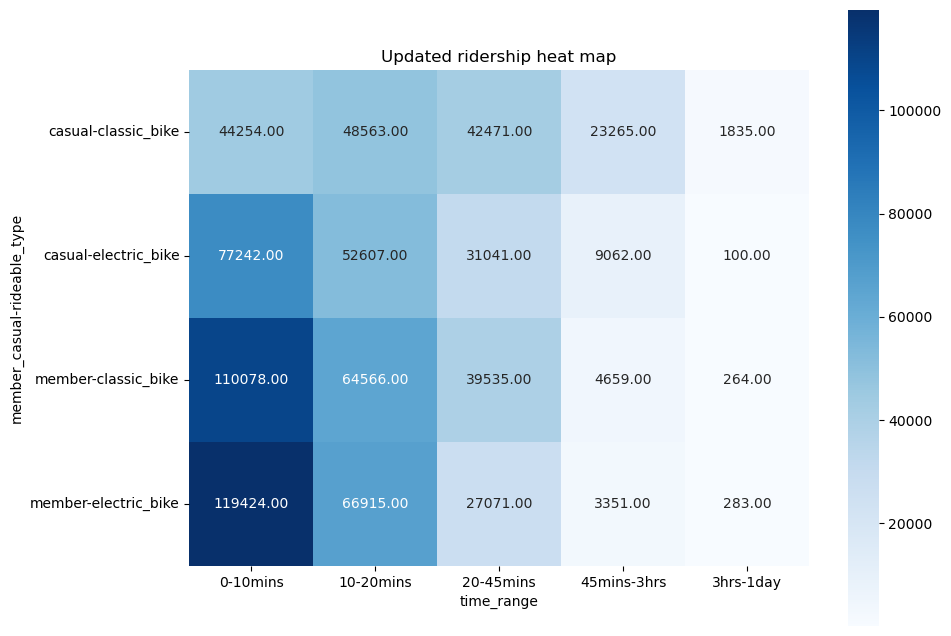

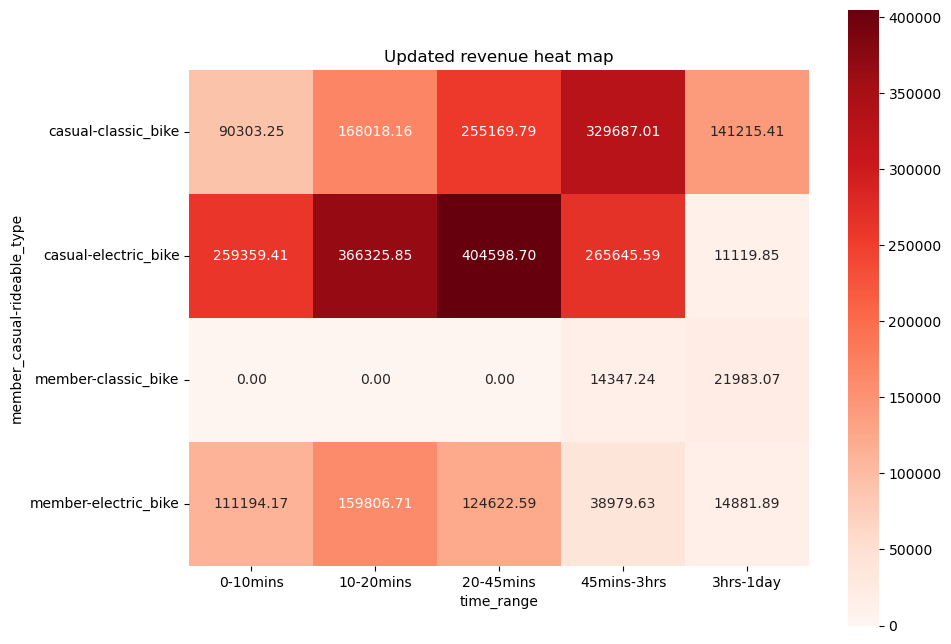

In [14]:
# After realizing the time range of beyond one day is probably not what the user intent to happen, it will be removed to show the most accurate data

# Remove the 'beyond 1 day' category for it to be removed later on
data['time_range'] = pd.Categorical(data['time_range'], categories=["0-10mins", "10-20mins", "20-45mins", "45mins-3hrs", "3hrs-1day"])
#data = data.sort_values('time_range')

# Remove the data with a time used that is more than one day
data = data[data['time_range'] != 'beyond 1 day']

# Same code used for generating the initial heatmaps

# Rearrange the data using pivot_table for the format to fit for heatmap generation
Time = data.pivot_table(index=['member_casual','rideable_type'], columns='time_range',values='time_used',aggfunc = 'count') # Count the number of entries
Cost = data.pivot_table(index=['member_casual','rideable_type'], columns='time_range',values='cost',aggfunc = 'sum') # Count the total income

# Create the heatmap for the time used and specify the size of the graph
plt.figure(figsize=(10, 8))
# This is a blue-shade heatmap wtih the numbers having 2 decimal places
sns.heatmap(Time, cmap='Blues', annot=True, fmt=".2f", cbar=True, square = True) 
plt.title('Updated ridership heat map')
plt.show()

# Create the heatmap for the revenue created and specify the size of the graph
plt.figure(figsize=(10, 8))
# This is a red-shade heatmap wtih the numbers having 2 decimal places
sns.heatmap(Cost, cmap='Reds',annot = True, fmt='.2f', cbar = True, square = True)
plt.title('Updated revenue heat map')
plt.show()

# Section 3 Inter-station Distances

## 1. Let us add a column specifying the day of the week on which each ride begins

In [13]:
# Create a day column 
data['day'] = np.nan

# Enter the day of each ride into the day column with a loop
for i in range(len(data)):
    
    data.loc[i,('day')] = data.loc[i,('started_at')].day_name()
    
data  

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_hour,end_hour,time_used,time_range,cost,day
0,9340B064F0AEE130,electric_bike,2023-07-23 20:06:14,2023-07-23 20:22:44,Kedzie Ave & 110th St,20204,Public Rack - Racine Ave & 109th Pl,877,41.692406,-87.700905,41.694835,-87.653041,member,20,20,16.500000,10-20mins,2.805000,Sunday
1,D1460EE3CE0D8AF8,classic_bike,2023-07-23 17:05:07,2023-07-23 17:18:37,Western Ave & Walton St,KA1504000103,Milwaukee Ave & Grand Ave,13033,41.898418,-87.686596,41.891578,-87.648384,member,17,17,13.500000,10-20mins,0.000000,Sunday
2,DF41BE31B895A25E,classic_bike,2023-07-23 10:14:53,2023-07-23 10:24:29,Western Ave & Walton St,KA1504000103,Damen Ave & Pierce Ave,TA1305000041,41.898418,-87.686596,41.909396,-87.677692,member,10,10,9.600000,0-10mins,0.000000,Sunday
3,9624A293749EF703,electric_bike,2023-07-21 08:27:44,2023-07-21 08:32:40,Racine Ave & Randolph St,13155,Clinton St & Madison St,TA1305000032,41.884112,-87.656943,41.882752,-87.641190,member,8,8,4.933333,0-10mins,0.838667,Friday
4,2F68A6A4CDB4C99A,classic_bike,2023-07-08 15:46:42,2023-07-08 15:58:08,Clark St & Leland Ave,TA1309000014,Montrose Harbor,TA1308000012,41.967088,-87.667291,41.963982,-87.638181,member,15,15,11.433333,10-20mins,0.000000,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767645,57F5743A5828DA62,electric_bike,2023-07-14 19:17:13,2023-07-14 19:26:31,NaN,NaN,California Ave & Division St,13256,41.910000,-87.680000,41.903029,-87.697474,member,19,19,9.300000,0-10mins,1.581000,Friday
767646,2FF218D4C8F0EF1C,electric_bike,2023-07-14 19:16:13,2023-07-14 19:16:16,NaN,NaN,NaN,NaN,41.910000,-87.680000,41.910000,-87.680000,member,19,19,0.050000,0-10mins,0.008500,Friday
767647,2661FBD1F5A1C76D,electric_bike,2023-07-15 13:34:00,2023-07-15 13:43:13,Wilton Ave & Belmont Ave,TA1307000134,NaN,NaN,41.940000,-87.650000,41.930000,-87.640000,member,13,13,9.216667,0-10mins,1.566833,Saturday
767648,9CF4B70C23E033B1,electric_bike,2023-07-06 20:52:09,2023-07-06 21:01:13,NaN,NaN,NaN,NaN,41.910000,-87.630000,41.930000,-87.640000,member,20,21,9.066667,0-10mins,1.541333,Thursday


## 2. Create column for distance between starting and ending stations

In [15]:
# Define the distance by using Vicenty's formula for ellispoids implemented in the geopy library
data.reset_index(drop=True)

data['interstation_distance'] = np.nan

missing_coords = data['end_lat'].isna().tolist()

for i in range(len(data)):

    if missing_coords[i] == False:

        data.loc[i,('interstation_distance')] = geopy.distance.geodesic((data.loc[i,('start_lat')],data.loc[i,('start_lng')]), (data.loc[i,('end_lat')],data.loc[i,('end_lng')])).km

    else:

        pass

In [16]:
data['distance_range'] = np.nan
for i in range(len(data)):
    
    if missing_coords[i] == False:
        
        if data.loc[i,('interstation_distance')] <=0: #assign the distance_range of 0 as 1
            data.loc[i,('distance_range')] = 'circuitous'
            
        elif data.loc[i,('interstation_distance')] <=1: #assign the distance_range from 0-1km as 2
            data.loc[i,('distance_range')] = '0-1km'
            
        elif data.loc[i,('interstation_distance')] <=2: #assign the distance_range from 1-2km as 3
            data.loc[i,('distance_range')] = '1-2km'
            
        elif data.loc[i,('interstation_distance')] <=3: #assign the distance_range from 2-3km as 4
            data.loc[i,('distance_range')] = '2-3km'
            
        elif data.loc[i,('interstation_distance')] <=5: #assign the distance_range from 3-5km as 5
            data.loc[i,('distance_range')] = '3-5km'
            
        elif data.loc[i,('interstation_distance')] <=10: #assign the distance_range beyond 5-10km as 6
            data.loc[i,('distance_range')] = 'beyond 10km'
            
        else: #assign the distance_range beyond 10km as 7
            data.loc[i,('distance_range')] = 'circuitous'
    else: #assign missing value
        data.loc[i,('distance_range')] = 'data missing'

print(data.groupby('distance_range')['interstation_distance'].count())  

distance_range
0-1km           168219
1-2km           234543
2-3km           132929
3-5km           119094
beyond 10km      61540
circuitous       50071
data missing         0
Name: interstation_distance, dtype: int64


## Visualization of the Inter-station Distances

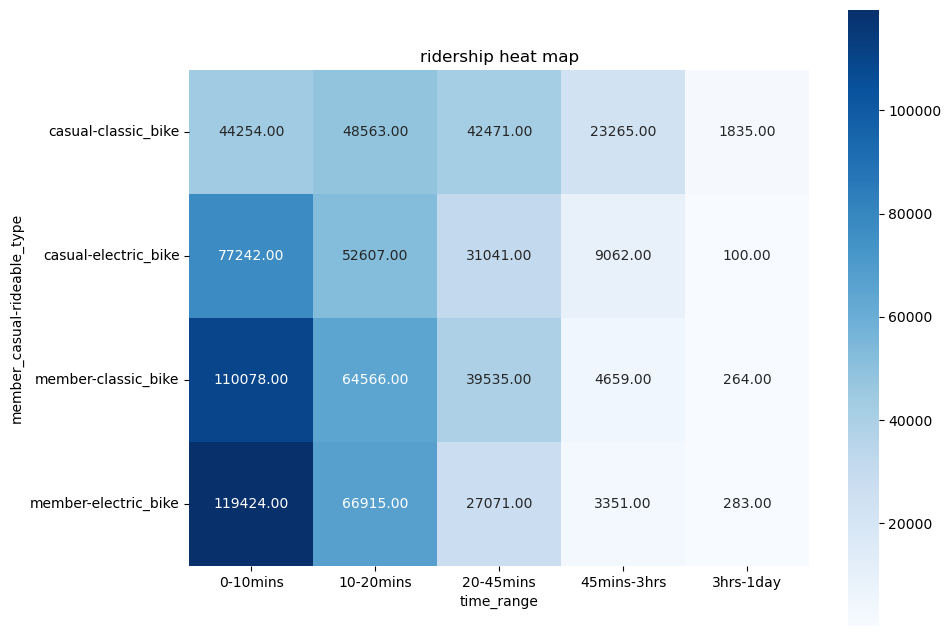

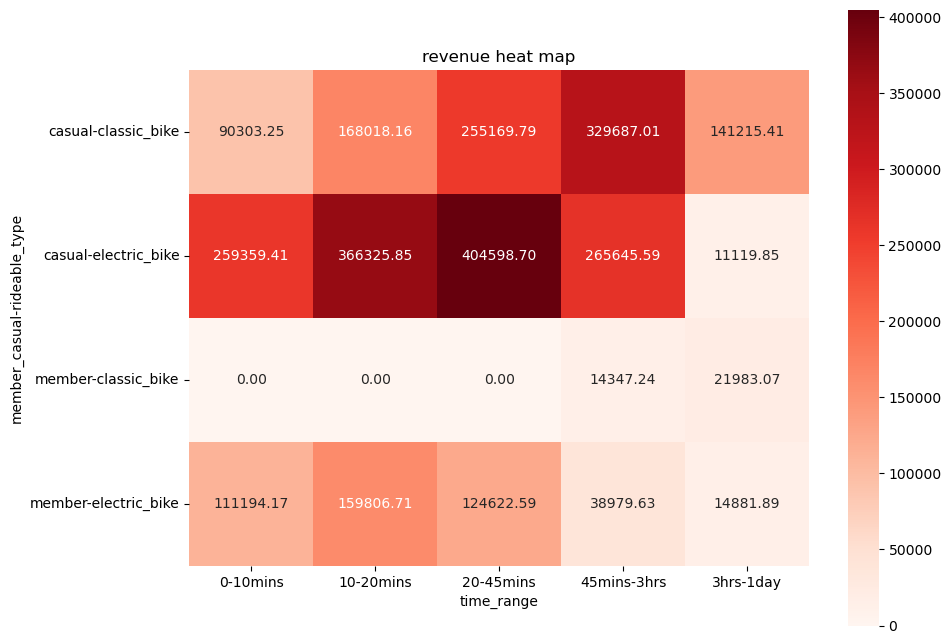

In [18]:
#This heatmap should contain the number of users with different time used as the x-value, and the different type of membership
    #plus the type of bikes as y-value
    
#modify the data to be added
hm1 = data.pivot_table(index=['member_casual','rideable_type'], columns='time_range',values='time_used',aggfunc = 'count')
hm2 = data.pivot_table(index=['member_casual','rideable_type'], columns='time_range',values='cost',aggfunc = 'sum')

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(hm1, cmap='Blues', annot=True, fmt=".2f", cbar=True, square = True)
plt.title('ridership heat map')
plt.show()


plt.figure(figsize=(10, 8))
sns.heatmap(hm2, cmap='Reds',annot = True, fmt='.2f', cbar = True, square = True)
plt.title('revenue heat map')
# Display the plot
plt.show()

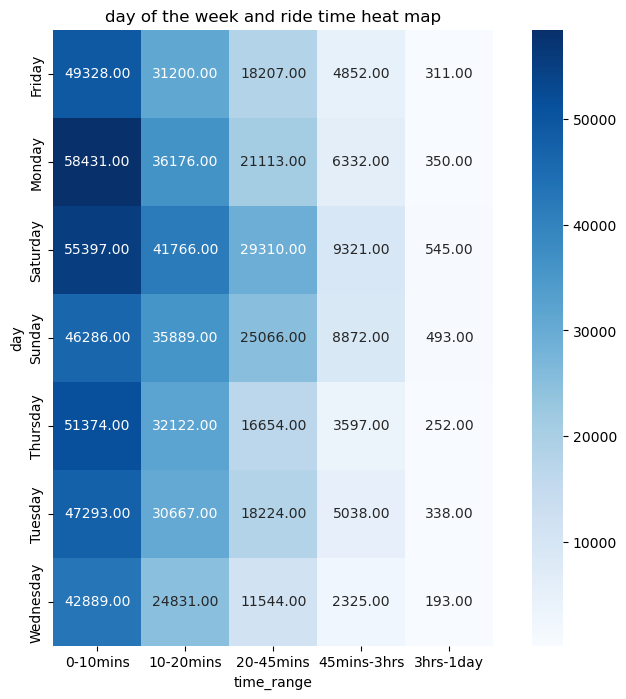

In [19]:
#This heatmap should contain the income from ridership level grouped by time on the x-axis,
    #plus the day of the week as y-value
    
#modify the data to be added
hm3 = data.pivot_table(index=['day'], columns='time_range',values='cost',aggfunc = 'count')


# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(hm3, cmap='Blues', annot=True, fmt=".2f", cbar=True, square = True)
plt.title('day of the week and ride time heat map')
plt.show()

In [20]:
data = data[data['distance_range'] != 'data missing']

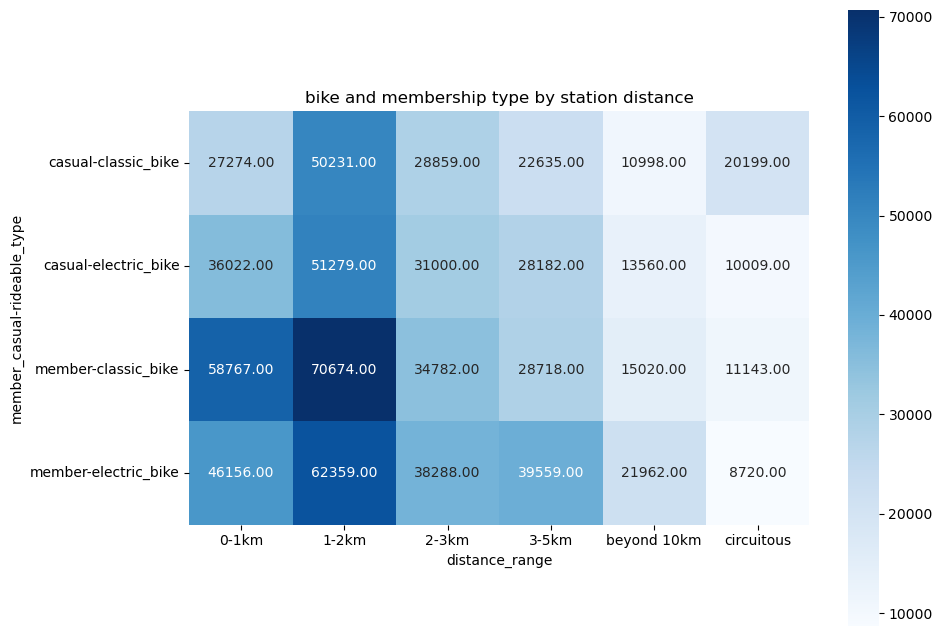

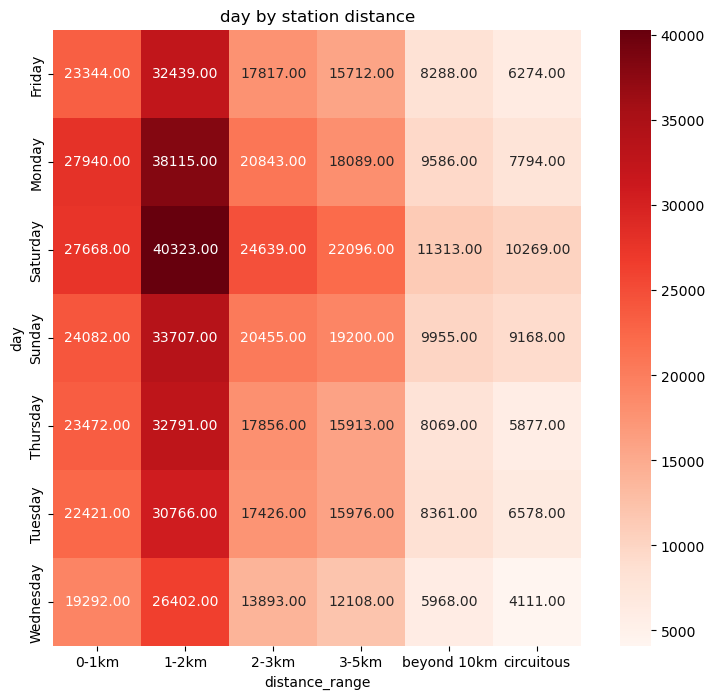

In [21]:
#This heatmap should contain the number of users with different interstation distance as the x-value, and the different type of membership
    #plus the type of bikes as y-value
    
#modify the data to be added
hm4 = data.pivot_table(index=['member_casual','rideable_type'], columns='distance_range',values='interstation_distance',aggfunc = 'count')
hm5 = data.pivot_table(index=['day'], columns='distance_range',values='interstation_distance',aggfunc = 'count')

# Create a heatmap
plt.figure(figsize=(10, 8))

sns.heatmap(hm4, cmap='Blues', annot=True, fmt=".2f", cbar=True, square = True)
plt.title('bike and membership type by station distance')
plt.show()


plt.figure(figsize=(10, 8))
sns.heatmap(hm5, cmap='Reds',annot = True, fmt='.2f', cbar = True, square = True)
plt.title('day by station distance')
# Display the plot
plt.show()

Text(0.5, 1.0, 'bike type by interstation distance box plot')

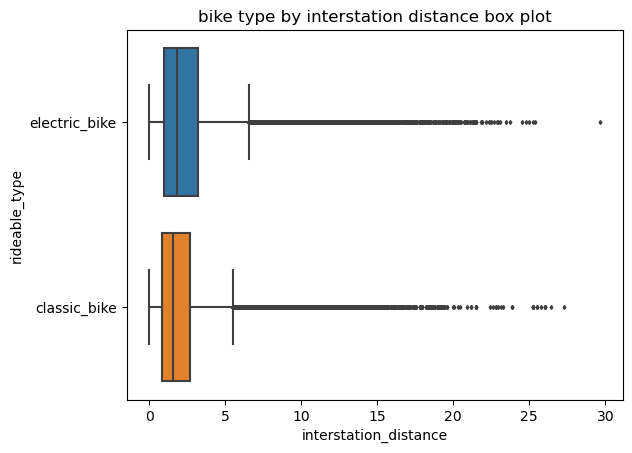

In [22]:
#This generates a box plot of the interstation distance
sns.boxplot(data = data, x = 'interstation_distance', y = 'rideable_type',fliersize = 2)
plt.title('bike type by interstation distance box plot')

In [23]:
#Find the count of each day
gk = data.groupby('day')
days = ['Mon','Tue','Wed','Thu','Friday','Sat','Sun']
#divide by the number of that particular day in the month of July to get average ridership
vals = [len(gk.get_group('Monday'))/5,len(gk.get_group('Tuesday'))/4,len(gk.get_group('Wednesday'))/4,len(gk.get_group('Thursday'))/4,len(gk.get_group('Friday'))/4,len(gk.get_group('Saturday'))/5,len(gk.get_group('Sunday'))/5]


In [24]:
#Write to a new dataframe
df = pd.DataFrame(vals, index = days, columns = ['riders_per_day'])
df

,riders_per_day
Mon,24473.4
Tue,25382.0
Wed,20443.5
Thu,25994.5
Friday,25968.5
Sat,27261.6
Sun,23313.4


Text(0.5, 1.0, 'ridership by day')

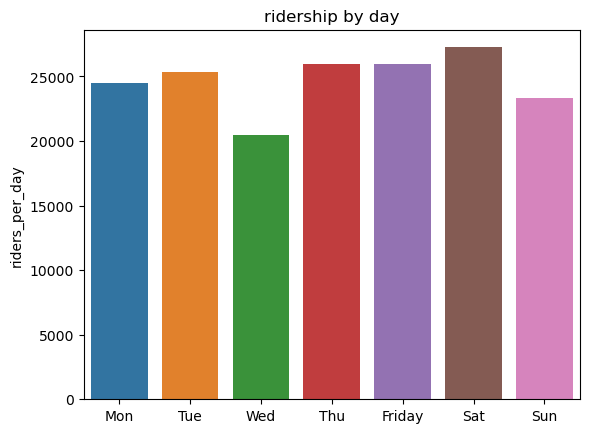

In [25]:
#Create barplots depending on day
sns.barplot(x=df.index, y='riders_per_day', data=df)
plt.title('ridership by day')
#### Since the city is relatively large and has a huge number of stations, we can further divide the city into distinct clusters based on the station coordinates. To do this, we implement K-means clustering.plt.ylabel('average ridership')

# Section 4 Cluster Analysis

## <b>Question: Are there distinct areas within the city based on station usage patterns? Which of these distinct areas classify as having high, medium, and low usage?</b>

In [26]:
unique_values = data['start_station_id'].nunique()
print(f'Number of Unique Start Station Names: {unique_values}')

Number of Unique Start Station Names: 1223


#### Since the city is relatively large and has a huge number of stations, we can further divide the city into distinct clusters based on the station coordinates. To do this, we implement K-means clustering.

## Apply K-means clustering with the starting station coordinates to group the stations into clusters based on their proximity.

#### For an easy and heuristic approach, we use the Elbow Method to find the optimal K-value for the clustering algorithm.

In [27]:
# Get the start coordinates for each observation in the data
start_coordinates = data[['start_lat', 'start_lng']]

In [28]:
# Define a range of clusters to test (Setting the maximum clusters to 20)
max_clusters = 20
cluster_range = range(1, max_clusters + 1)
distortions = [] # Inertia or within-cluster sum of squares (Lower = better clustering)
distortion_decrease = [] # If there is no significant decrease in the distortion, then it is not ideal

In [29]:
# Get the distortion of each cluster
for i in cluster_range:
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=0)
    kmeans.fit(start_coordinates)
    distortion_decrease.append(distortions[i-2] - kmeans.inertia_ if i - 2 >= 0 else None)
    print("Cluster " + str(i) + " Distortion: " + str(kmeans.inertia_) + "  |  Decrease: " +  str(distortion_decrease[-1]))
    distortions.append(kmeans.inertia_)

Cluster 1 Distortion: 1948.7224780498107  |  Decrease: None
Cluster 2 Distortion: 1012.8606128901556  |  Decrease: 935.861865159655
Cluster 3 Distortion: 710.2431120918345  |  Decrease: 302.6175007983211
Cluster 4 Distortion: 555.7682062841968  |  Decrease: 154.4749058076377
Cluster 5 Distortion: 434.7192358078451  |  Decrease: 121.04897047635171
Cluster 6 Distortion: 373.00914935991153  |  Decrease: 61.71008644793358
Cluster 7 Distortion: 322.3221232872891  |  Decrease: 50.687026072622416
Cluster 8 Distortion: 284.6491845297382  |  Decrease: 37.672938757550924
Cluster 9 Distortion: 254.72500067440123  |  Decrease: 29.924183855336963
Cluster 10 Distortion: 221.16079637417502  |  Decrease: 33.56420430022621
Cluster 11 Distortion: 200.968960137269  |  Decrease: 20.191836236906028
Cluster 12 Distortion: 185.4029776760578  |  Decrease: 15.565982461211206
Cluster 13 Distortion: 172.14421002672455  |  Decrease: 13.258767649333237
Cluster 14 Distortion: 158.92468173160387  |  Decrease: 13.219

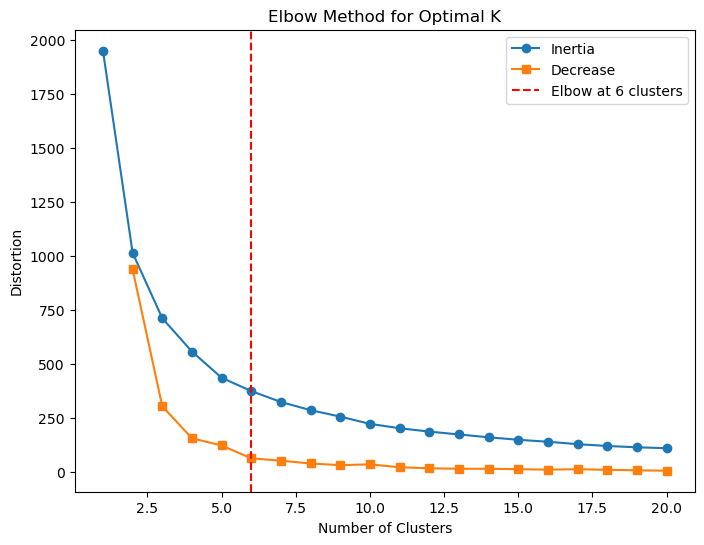

In [30]:
# Plot the elbow method (Showing that the "elbow" is at 6 clusters)
plt.figure(figsize=(8, 6))

plt.plot(cluster_range, distortions, marker='o', label='Inertia')
plt.plot(cluster_range, distortion_decrease, marker='s', label='Decrease')
plt.axvline(x=6, color='red', linestyle='--', label='Elbow at 6 clusters')

plt.legend()
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')

plt.show()

#### Through the Elbow method, we identify the optimal K-value for the K-Means Clustering Algorithm which is k = 6. We use this k-value to create our KMeans model, fit the data to the model, and assign labels for each observation.

In [31]:
# Initialize KMeans model
kmeans = KMeans(n_clusters=6, n_init=10)

# Fit the KMeans model to start coordinates
kmeans.fit(start_coordinates)

# Get the cluster labels for each station
cluster_labels = kmeans.predict(start_coordinates)
cluster_labels = cluster_labels + 1

# Add cluster labels to the DataFrame
data['cluster'] = cluster_labels

#### After preparing the clusters, we plot them to show the distinct areas wherein users usually start using the bikes.

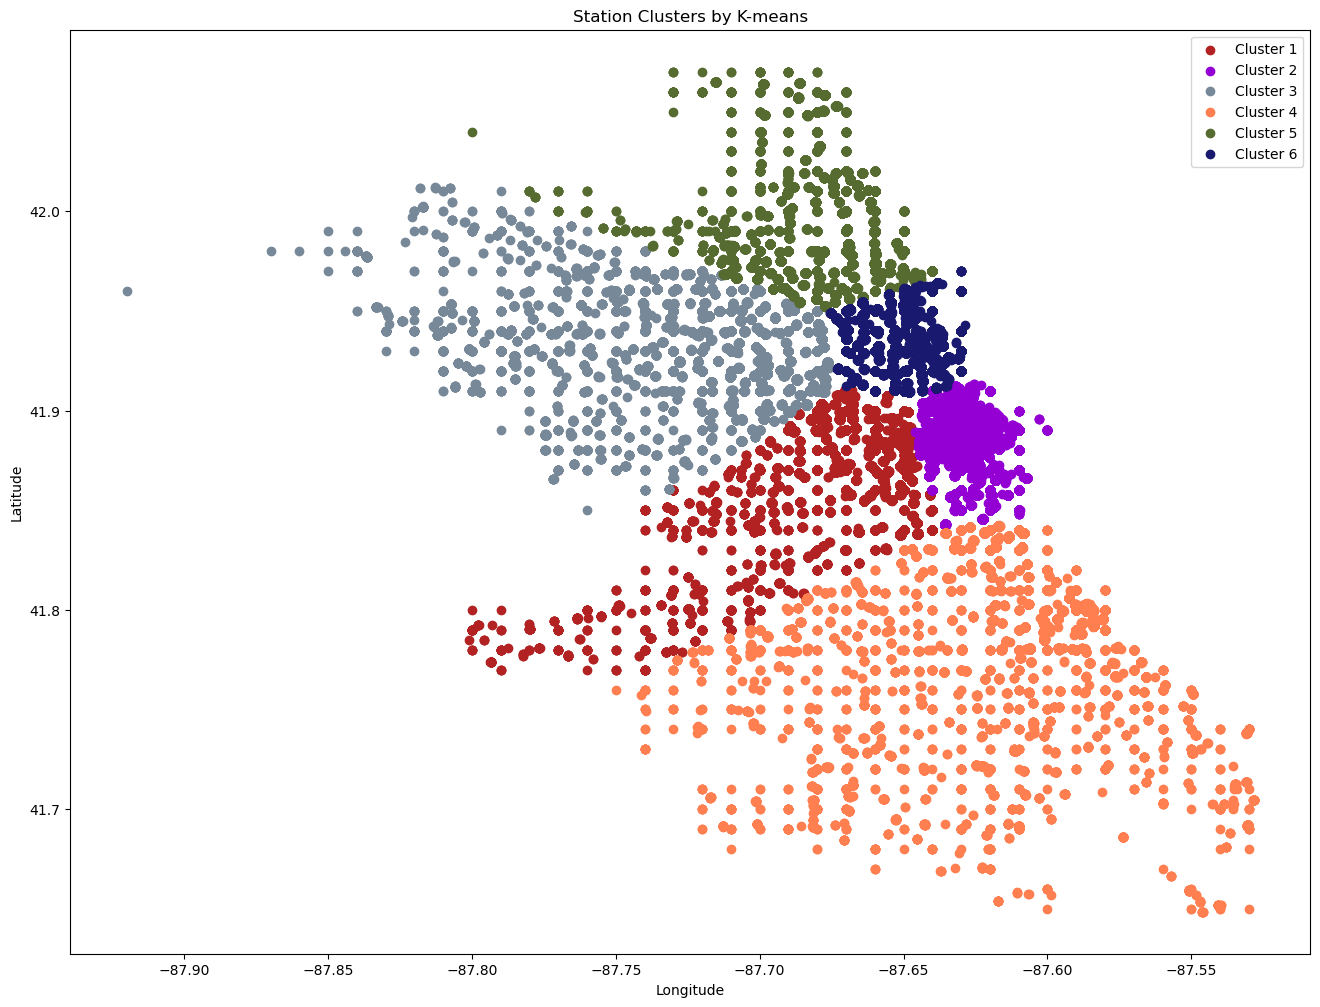

In [32]:
colors = ['firebrick', 'darkviolet', 'lightslategray', 'coral', 'darkolivegreen', 'midnightblue']

# Plotting the clustered stations on a scatter plot
plt.figure(figsize=(16, 12))

for cluster_label in range(1,7):
    cluster = data[data['cluster'] == cluster_label]
    plt.scatter(cluster['start_lng'], cluster['start_lat'], label=f'Cluster {cluster_label}', color=colors[cluster_label-1])

plt.title('Station Clusters by K-means')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

#### We also use a bar graph to show the frequency of usage for each cluster. Furthermore, we divide the graph into three using the lower and upper quantile to identify the areas with high, medium, and low usage.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


   Cluster  Number of Coordinates
2        1                  99252
0        2                 292910
4        3                  61014
5        4                  41776
3        5                  66264
1        6                 205180


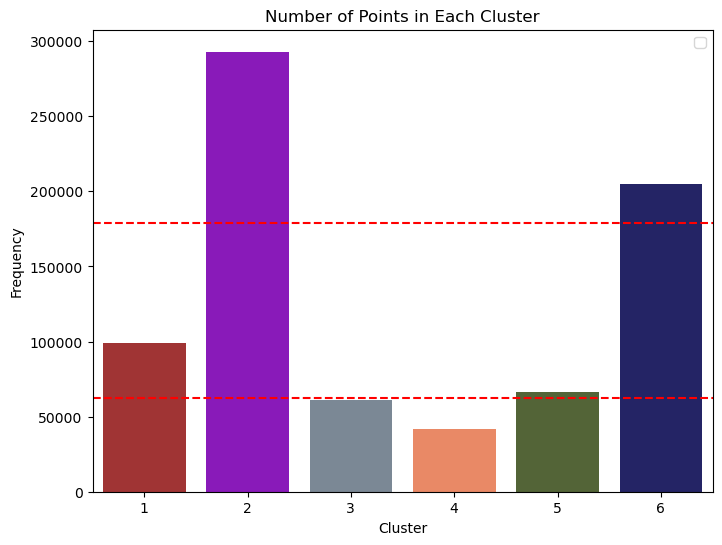

In [33]:
# Get the number of points in each cluster
cluster_counts = data['cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Number of Coordinates']
print(cluster_counts.sort_values('Cluster'))

# Plotting the barplot
plt.figure(figsize=(8, 6))
sns.barplot(x='Cluster', y='Number of Coordinates', data=cluster_counts, palette=colors)
plt.title('Number of Points in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency')

# Setup divisions for high, medium, low usage areas
plt.axhline(y=cluster_counts['Number of Coordinates'].quantile(0.25), color='red', linestyle='--')
plt.axhline(y=cluster_counts['Number of Coordinates'].quantile(0.75), color='red', linestyle='--')

plt.legend()
plt.show()

## Station Utilization and Demand
### <b>Proposed Solutions:</b>
- Increase Bikes at Popular Stations (In clusters with high usage) to ensure there's sufficient bikes at high-demand stations.
- Promotions such as discounts and incentives for less utilized stations (In clusters with low usage) to encourage ridership at stations with low traffic.
In doing the proposed solutions, we can strike a balance and maximize the distributions of bikes while also improving ridership among the business' customers.

In [ ]:
gk = data.groupby('cluster')

for i in range(1,7):
    df = gk.get_group(i)[['start_lat','start_lng']].reset_index(drop=True)
    df.to_csv('DATA100_cluster_'+str(i)+'_values.csv',index = False)